In [3]:
import os
import pandas as pd

# show numbers with commas - DATAFRAME GLOBAL SETTING
pd.options.display.float_format = '{:,.0f}'.format

# Import Processed Data

### Important: first unzip intermediate\CCSHourDirLane.csv

Using ArcGIS Pro jupyter environment: https://developers.arcgis.com/python/guide/using-the-jupyter-notebook-environment/

In [4]:
# read csv into dataframe, parse_dates sets what fields are dates so correct datat type is used, low memory = False removes warning for big file import
dfHourData = pd.read_csv('intermediate\CCSHourDirLane.csv',parse_dates=['DATE'],low_memory=False)
display(dfHourData)

,STATION,DATE,ROUTE,MP,LANE,HOUR,HOURVOL,DIR
0,301,2019-01-01,80,129,1,0,116,NEG
1,301,2019-01-01,80,129,2,0,236,NEG
2,301,2019-01-01,80,129,3,0,62,NEG
3,301,2019-01-01,80,129,1,0,70,POS
4,301,2019-01-01,80,129,2,0,158,POS
...,...,...,...,...,...,...,...,...
4103120,716,2019-07-29,18,3,2,2300,62,NEG
4103121,716,2019-07-29,18,3,3,2300,112,NEG
4103122,716,2019-07-29,18,3,1,2300,3,POS
4103123,716,2019-07-29,18,3,2,2300,42,POS


In [5]:
# check data types
dfHourData.dtypes

STATION             int64
DATE       datetime64[ns]
ROUTE              object
MP                float64
LANE                int64
HOUR                int64
HOURVOL           float64
DIR                object
dtype: object

In [6]:
# count number of stations
print ('There are ' + str(dfHourData['STATION'].unique().size) + ' stations')
print ('Station list: ' + str(dfHourData['STATION'].unique()))
display (dfHourData[['STATION','ROUTE','MP']].drop_duplicates())

There are 139 stations
Station list: [301 302 303 304 305 306 307 308 309 310 312 313 314 315 316 317 318 319
 320 321 322 324 325 327 329 332 333 335 340 348 349 350 351 353 354 355
 362 363 382 402 403 404 405 406 407 408 411 412 414 416 418 420 421 424
 425 430 431 501 502 503 504 507 508 509 510 511 512 513 601 602 605 606
 609 611 612 613 614 615 616 617 619 620 621 622 623 624 625 626 627 628
 629 630 631 632 633 634 635 636 637 638 639 641 642 643 644 645 646 647
 648 649 650 651 653 654 655 656 657 658 659 660 661 662 663 665 667 669
 670 671 672 674 702 703 704 711 712 713 714 715 716]


,STATION,ROUTE,MP
0,301,80,129
1764,302,15,291
5625,303,91,45
6953,304,89,500
7605,305,24,8
...,...,...,...
166281,712,7,1
167529,713,7,5
168805,714,7,7
169455,715,9,31


# Calculate daily volumes from hourly data, aggregate 

In [7]:
# for each station calculate daily volumes, num records reprsents number of hours x number of lanes x directions
dfDailyVolumes = dfHourData.groupby(['STATION','ROUTE','MP','DATE'],as_index=False).agg(DAILYVOL=('HOURVOL','sum'),NUMREC=('HOURVOL','count'))
display(dfDailyVolumes)

,STATION,ROUTE,MP,DATE,DAILYVOL,NUMREC
0,301,80,129,2019-01-01,"46,081",144
1,301,80,129,2019-01-02,"59,924",144
2,301,80,129,2019-01-03,"60,211",144
3,301,80,129,2019-01-04,"63,467",144
4,301,80,129,2019-01-05,"58,449",144
...,...,...,...,...,...,...
36291,716,18,3,2019-06-27,"17,194",144
36292,716,18,3,2019-06-28,"17,602",144
36293,716,18,3,2019-06-29,"15,212",144
36294,716,18,3,2019-06-30,"9,739",144


# Filter data for a specific station and day of weeks

In [8]:
filterStations = [301,510] #[301,510]
filterDaysOfWeek = [2,3,4] # (Monday=0,Sunday=6), [2,3,4] = Tuesday through Thursday

# filter data by station number and weekday 
dfDailyVolume_filtered = dfDailyVolumes[(dfDailyVolumes['STATION'].isin(filterStations)) &
                                        (dfDailyVolumes['DATE'   ].dt.weekday.isin(filterDaysOfWeek))].copy()
display(dfDailyVolume_filtered)

,STATION,ROUTE,MP,DATE,DAILYVOL,NUMREC
1,301,80,129,2019-01-02,"59,924",144
2,301,80,129,2019-01-03,"60,211",144
3,301,80,129,2019-01-04,"63,467",144
8,301,80,129,2019-01-09,"57,535",144
9,301,80,129,2019-01-10,"57,851",144
...,...,...,...,...,...,...
20355,510,218,8,2019-12-19,"4,727",48
20356,510,218,8,2019-12-20,"4,679",48
20361,510,218,8,2019-12-25,"2,141",48
20362,510,218,8,2019-12-26,"3,154",48


# Calculate monthly stats for filtered dataframe

In [9]:
# add month column to data
dfDailyVolume_filtered['MONTH'] = dfDailyVolume_filtered['DATE'].dt.month

# aggregate by station and month and calculate stats for each
dfMonthStats = dfDailyVolume_filtered.groupby(['STATION','MONTH']).agg(AVGVOL =('DAILYVOL','mean' ),
                                                                       MINVOL =('DAILYVOL','min'  ),
                                                                       MAXVOL =('DAILYVOL','max'  ),
                                                                       STDEV  =('DAILYVOL','std'  ),
                                                                       NUMDAYS=('DAILYVOL','count'))

display(dfMonthStats)

AVGVOL  MINVOL  MAXVOL  STDEV  NUMDAYS
STATION MONTH                                        
301     1      60,012  46,167  71,933  6,658       14
        2      51,962   5,588  69,764 17,435       12
        3      57,830  42,984  65,737  6,263       13
        4      54,921  43,169  61,464  4,828       12
        5      58,784  55,493  62,789  2,327       13
        6      70,220  63,983  80,129  4,499       12
        9      67,522  60,238  74,663  4,240       12
        10     60,866  33,929  70,589  8,876       14
        11     53,444  28,291  64,189 11,278       13
        12     58,417  32,834  69,256  9,104       12
510     1       4,400   4,034   4,619    158       14
        2       4,451   4,155   4,880    212       12
        3       4,540   3,897   5,011    307       13
        4       4,649   3,603   5,437    608       12
        5       5,382   4,563   5,921    365       15
        6       4,863   4,273   5,438    369       12
        7       4,565   3,212   5,862    648       13
        8       5,076   4,993   5,159    117        2
        9       5,818   4,962   6,628    573       12
        10      4,769   3,870   5,777    516       14
        11      4,270   2,619   4,833    661       13
        12      4,193   2,141   4,779    830       12

<AxesSubplot:>

<AxesSubplot:>

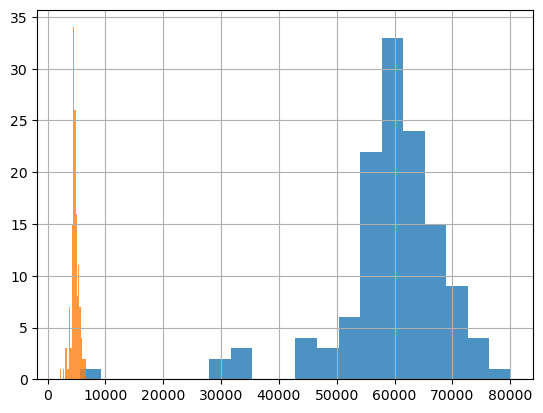

In [10]:
# make histogram of volumes by station
# alpha sets opacity, bins sets number of bin
for s in filterStations:
    display(dfDailyVolume_filtered[dfDailyVolume_filtered['STATION']==s]['DAILYVOL'].hist(bins=20,alpha=0.8))